100%|██████████| 170498071/170498071 [00:55<00:00, 3092245.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
[1/5][0/391]	Loss_D: 1.6541	Loss_G: 3.2476	D(x): 0.3586	D(G(z)): 0.3338/0.0502
[1/5][100/391]	Loss_D: 0.3864	Loss_G: 4.4965	D(x): 0.7998	D(G(z)): 0.0294/0.0257
[1/5][200/391]	Loss_D: 0.4588	Loss_G: 4.2108	D(x): 0.7922	D(G(z)): 0.0555/0.0446
[1/5][300/391]	Loss_D: 0.0981	Loss_G: 5.9187	D(x): 0.9377	D(G(z)): 0.0046/0.0048


/Users/mikeshinoda/Library/Caches/pypoetry/virtualenvs/ai-algo-ozOH1ZQc-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mikeshinoda/Library/Caches/pypoetry/virtualenvs/ai-algo-ozOH1ZQc-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mikeshinoda/Library/Caches/pypoetry/virtualenvs/ai-algo-ozOH1ZQc-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mikeshinoda/Library/Caches/pypoetry/virtualenvs/ai-algo-ozOH1ZQc-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFI

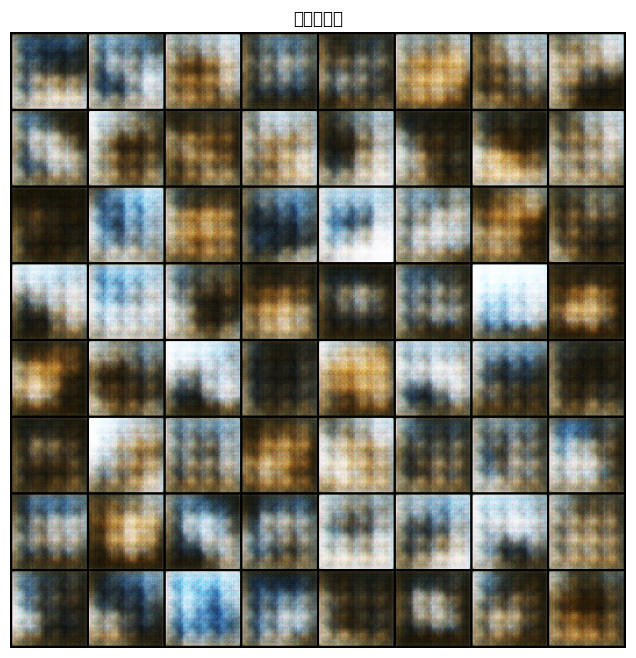

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# 设置超参数
batch_size = 128
image_size = 64
nc = 3  # 输入图片的通道数（对于彩色图像为3）
nz = 100  # 潜在向量的维度
ngf = 64  # 生成器中特征图数量
ndf = 64  # 判别器中特征图数量
num_epochs = 5
lr = 0.0002
beta1 = 0.5  # Adam优化器的beta1超参数

# 判断是否可以使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * nc, [0.5] * nc)  # 将像素值归一化到[-1, 1]
])

# 加载CIFAR-10数据集
dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# 定义生成器网络
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 输入是Z，形状为 (batch_size, nz, 1, 1)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 形状变为 (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 形状变为 (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 形状变为 (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 形状变为 (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输出形状为 (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


# 定义判别器网络
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 输入是 (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 形状变为 (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 形状变为 (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 形状变为 (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 形状变为 (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # 输出形状为 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input).view(-1)


# 创建网络实例
netG = Generator().to(device)
netD = Discriminator().to(device)


# 初始化权重
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


netG.apply(weights_init)
netD.apply(weights_init)

# 定义损失函数和优化器
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# 开始训练
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) 更新判别器网络：最大化log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## 训练真实样本
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        labels = torch.full((b_size,), 1., dtype=torch.float, device=device)  # 真实标签为1
        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        ## 训练生成的假样本
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(0.)  # 假标签为0
        output = netD(fake_images.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        ## 总的判别器损失
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) 更新生成器网络：最大化log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(1.)  # 生成器希望判别器认为生成的样本是真实的
        output = netD(fake_images)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # 输出训练状态
        if i % 100 == 0:
            print(f'[{epoch + 1}/{num_epochs}][{i}/{len(dataloader)}]\t'
                  f'Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t'
                  f'D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

    # 每个epoch结束后，保存生成的图片
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    grid = vutils.make_grid(fake, padding=2, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("生成的图像")
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()
